In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from sklearn.model_selection import train_test_split

train_df_whole = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
the_filter = train_df_whole["EncodedPixels"].isna()
train_df_whole = train_df_whole[~the_filter]
train_df_whole["image_id"] = train_df_whole["ImageId_ClassId"].str[:-2]
train_df_whole["class_id"] = train_df_whole["ImageId_ClassId"].str[-1].astype("float")
train_df_whole.drop("ImageId_ClassId", axis=1, inplace=True)
train_df_whole.reset_index(drop=True, inplace=True)

train_df, validate_df = train_test_split(train_df_whole, test_size=0.1, stratify=train_df_whole[["class_id"]].copy())
train_df.reset_index(drop=True, inplace=True)
validate_df.reset_index(drop=True, inplace=True)

train_df["image_id"].value_counts()
validate_df["image_id"].value_counts()

7b08e8584.jpg    2
843f0ae15.jpg    2
69f290a7f.jpg    2
e9b77950e.jpg    2
949a23e72.jpg    2
                ..
74abdf1ef.jpg    1
534666b46.jpg    1
19955420c.jpg    1
2490c490c.jpg    1
579a51c1b.jpg    1
Name: image_id, Length: 704, dtype: int64

In [3]:
from numpy import zeros, flipud, rot90, uint8, asarray, float32
def rle2mask(rle, imgshape):
    # width = imgshape[0]
    width = imgshape[1]
    # height= imgshape[1]
    height = imgshape[0]
    
    #mask= np.zeros( width*height ).astype(np.uint8)
    # mask= zeros( width*height ).astype(uint8)
    mask= zeros( width*height )
    
    #array = np.asarray([int(x) for x in rle.split()])
    array = asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
        
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = float32(1.0)
        
    # return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )
    return flipud( rot90( mask.reshape(width, height), k=1 ) )

In [4]:
#import os
from keras.preprocessing.image import ImageDataGenerator, save_img, array_to_img  #, load_img
#import shutil
#from PIL import Image
from os.path import exists, join, isfile
from os import mkdir, listdir, unlink
from numpy import expand_dims, round
from shutil import copyfile

data_dir = "/kaggle/data"
if not exists(data_dir):
    mkdir(data_dir)

masks_dir = "/kaggle/data/masks"
if not exists(masks_dir):
    mkdir(masks_dir)
masks_subdir = "/kaggle/data/masks/masks"
if not exists(masks_subdir):
    mkdir(masks_subdir)
    
for the_file in listdir(masks_subdir):
    file_path = join(masks_subdir, the_file)
    try:
        if isfile(file_path):
            unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

images_dir = "/kaggle/data/images"
if not exists(images_dir):
    mkdir(images_dir)
images_subdir = "/kaggle/data/images/images"
if not exists(images_subdir):
    mkdir(images_subdir)

for the_file in listdir(images_subdir):
    file_path = join(images_subdir, the_file)
    try:
        if isfile(file_path):
            unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
    
validation_data_dir = "/kaggle/validation_data"
if not exists(validation_data_dir):
    mkdir(validation_data_dir)
    
validation_masks_dir = "/kaggle/validation_data/masks"
if not exists(validation_masks_dir):
    mkdir(validation_masks_dir)
validation_masks_subdir = "/kaggle/validation_data/masks/masks"
if not exists(validation_masks_subdir):
    mkdir(validation_masks_subdir)
    
for the_file in listdir(validation_masks_subdir):
    file_path = join(validation_masks_subdir, the_file)
    try:
        if isfile(file_path):
            unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
    
validation_images_dir = "/kaggle/validation_data/images"
if not exists(validation_images_dir):
    mkdir(validation_images_dir)
validation_images_subdir = "/kaggle/validation_data/images/images"
if not exists(validation_images_subdir):
    mkdir(validation_images_subdir)

for the_file in listdir(validation_images_subdir):
    file_path = join(validation_images_subdir, the_file)
    try:
        if isfile(file_path):
            unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

the_height = 256
the_width = 1600

imgshape = (the_height, the_width)
orig_train_dir = "/kaggle/input/severstal-steel-defect-detection/train_images/"
#the_index = 0
for file_name, rle, class_id in zip(train_df["image_id"], train_df["EncodedPixels"], train_df["class_id"]):
    the_mask = rle2mask(rle, imgshape)
    the_mask = expand_dims(the_mask, 2)
    mask_file_name = file_name[:-4] + "_" + str(int(class_id)) + "_mask.png"
    image_file_name = file_name[:-4] + "_" + str(int(class_id)) + "_image.jpg"
    save_img(masks_subdir + "/" + mask_file_name, the_mask, data_format="channels_last", scale=False)
    src = join(orig_train_dir, file_name)
    dst = join(images_subdir, image_file_name)
    copyfile(src, dst)
    #the_index = the_index + 1
    #if the_index == 100:
    #    break

imgshape = (the_height, the_width)
orig_train_dir = "/kaggle/input/severstal-steel-defect-detection/train_images/"
#the_index = 0
for file_name, rle, class_id in zip(validate_df["image_id"], validate_df["EncodedPixels"], validate_df["class_id"]):
    the_mask = rle2mask(rle, imgshape)
    the_mask = expand_dims(the_mask, 2)
    mask_file_name = file_name[:-4] + "_" + str(int(class_id)) + "_mask.png"
    image_file_name = file_name[:-4] + "_" + str(int(class_id)) + "_image.jpg"
    save_img(validation_masks_subdir + "/" + mask_file_name, the_mask, data_format="channels_last", scale=False)
    src = join(orig_train_dir, file_name)
    dst = join(validation_images_subdir, image_file_name)
    copyfile(src, dst)
    #the_index = the_index + 1
    #if the_index == 100:
    #    break
        
train_batch_size = 4
validate_batch_size = 4

data_gen_args_image = dict(
    rotation_range=135.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255.0
)

def round_pixels(image):
    return round(image)

data_gen_args_mask = dict(
    rotation_range=135.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=round_pixels
)

# we create two instances with the same arguments
image_datagen = ImageDataGenerator(**data_gen_args_image)
mask_datagen = ImageDataGenerator(**data_gen_args_mask)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow_from_directory(
    '/kaggle/data/images',
    target_size=(the_height, the_width),
    batch_size=train_batch_size,
    color_mode="rgb",
    class_mode=None,
    seed=seed
)

mask_generator = mask_datagen.flow_from_directory(
    '/kaggle/data/masks',
    target_size=(the_height, the_width),
    batch_size=train_batch_size,
    color_mode="grayscale",
    class_mode=None,
    seed=seed
)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# the_index = 0
# fig_index = 1
# for the_image, the_mask in train_generator:
#     plt.figure(fig_index)
#     the_image = np.squeeze(the_image, 0)
#     the_image = array_to_img(the_image)
#     plt.imshow(the_image)
#     
#     fig_index = fig_index + 1
#     plt.figure(fig_index)
#     the_mask = np.squeeze(the_mask, 0)
#     the_mask = array_to_img(the_mask)
#     plt.imshow(the_mask)
#     
#     fig_index = fig_index + 1
#     
#     the_index = the_index + 1
#     if the_index == 5:
#         break

validation_image_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_mask_datagen = ImageDataGenerator(preprocessing_function=round_pixels)
        
seed = 10
validation_image_generator = validation_image_datagen.flow_from_directory(
    '/kaggle/validation_data/images',
    target_size=(the_height, the_width),
    batch_size=validate_batch_size,
    color_mode="rgb",
    class_mode=None,
    seed=seed
)

validation_mask_generator = validation_mask_datagen.flow_from_directory(
    '/kaggle/validation_data/masks',
    target_size=(the_height, the_width),
    batch_size=validate_batch_size,
    color_mode="grayscale",
    class_mode=None,
    seed=seed
)

# combine generators into one which yields image and masks
validation_generator = zip(validation_image_generator, validation_mask_generator)

# the_index = 0
# fig_index = 11
# for the_image, the_mask in train_generator:
#     plt.figure(fig_index)
#     the_image = np.squeeze(the_image, 0)
#     the_image = array_to_img(the_image)
#     plt.imshow(the_image)
#     
#     fig_index = fig_index + 1
#     plt.figure(fig_index)
#     the_mask = np.squeeze(the_mask, 0)
#     the_mask = array_to_img(the_mask)
#     plt.imshow(the_mask)
#     
#     fig_index = fig_index + 1
#     
#     the_index = the_index + 1
#     if the_index == 5:
#         break

Using TensorFlow backend.


Found 6385 images belonging to 1 classes.
Found 6385 images belonging to 1 classes.
Found 710 images belonging to 1 classes.
Found 710 images belonging to 1 classes.


In [5]:
import keras.backend as K
from keras.losses import binary_crossentropy

def dice_metric(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.cast(K.round(K.flatten(y_true)), "float32")
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1.0 - dice_metric(y_true, y_pred)

In [6]:
from keras.applications import VGG16
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, Dropout
from keras.models import Model
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers.merge import concatenate

the_rate = 0.5

#conv_base = Xception(weights="/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(320, 320, 3))
conv_base = VGG16(weights="/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(the_height, the_width, 3))

for layer in conv_base.layers:
    layer.trainable = False

for num_layers in range(8):
    conv_base.layers.pop()
    conv_base.layers[-1].outbound_nodes = []

u1 = conv_base.layers[-1].output

u2 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u1)
u2 = BatchNormalization()(u2)
u2 = Activation("relu")(u2)
u2 = Dropout(the_rate)(u2)
u3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u2)
u3 = BatchNormalization()(u3)
u3 = Activation("relu")(u3)
u3 = Dropout(the_rate)(u3)
u4 = UpSampling2D((2, 2), interpolation='bilinear')(u3)
u5 = Conv2D(256, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u4)
u5 = BatchNormalization()(u5)
u5 = Activation("relu")(u5)
u5 = Dropout(the_rate)(u5)
u6 = concatenate([u5, conv_base.get_layer("block3_conv3").output])

u7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u6)
u7 = BatchNormalization()(u7)
u7 = Activation("relu")(u7)
u7 = Dropout(the_rate)(u7)
u8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u7)
u8 = BatchNormalization()(u8)
u8 = Activation("relu")(u8)
u8 = Dropout(the_rate)(u8)
u9 = UpSampling2D((2, 2), interpolation='bilinear')(u8)
u10 = Conv2D(128, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u9)
u10 = BatchNormalization()(u10)
u10 = Activation("relu")(u10)
u10 = Dropout(the_rate)(u10)
u11 = concatenate([u10, conv_base.get_layer("block2_conv2").output])

u12 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u11)
u12 = BatchNormalization()(u12)
u12 = Activation("relu")(u12)
u12 = Dropout(the_rate)(u12)
u13 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u12)
u13 = BatchNormalization()(u13)
u13 = Activation("relu")(u13)
u13 = Dropout(the_rate)(u13)
u14 = UpSampling2D((2, 2), interpolation='bilinear')(u13)
u15 = Conv2D(64, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u14)
u15 = BatchNormalization()(u15)
u15 = Activation("relu")(u15)
u15 = Dropout(the_rate)(u15)
u16 = concatenate([u15, conv_base.get_layer("block1_conv2").output])

u17 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u16)
u17 = BatchNormalization()(u17)
u17 = Activation("relu")(u17)
u17 = Dropout(the_rate)(u17)
u18 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", data_format="channels_last", kernel_initializer="he_normal")(u17)
u18 = BatchNormalization()(u18)
u18 = Activation("relu")(u18)
output = Conv2D(1, (1, 1), activation='sigmoid')(u18)

model = Model(inputs=conv_base.input, outputs=output)
model.summary()

callbacks_list = [
    # EarlyStopping(monitor="acc", patience=2),
    ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=1, cooldown=2, min_lr=1.0e-6, verbose=1),
    #TensorBoard(log_dir="./log_dir", histogram_freq=1)
]

model.compile(loss=dice_loss, optimizer=optimizers.Adam(lr=1.0e-4), metrics=[dice_metric])

train_set_size = train_df.shape[0]
if train_batch_size == train_set_size:
    steps_per_epoch = 1
else:
    steps_per_epoch = (train_set_size // train_batch_size) + 1

validate_set_size = validate_df.shape[0]
if validate_batch_size == validate_set_size:
    validate_steps_per_epoch = 1
else:
    validate_steps_per_epoch = (validate_set_size // validate_batch_size) + 1

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps = validate_steps_per_epoch,
    callbacks=callbacks_list
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 1600, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 1600, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 800, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

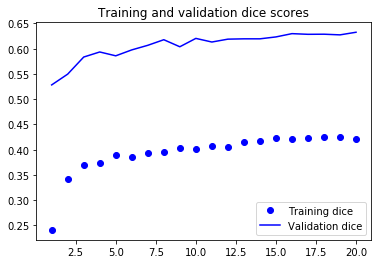

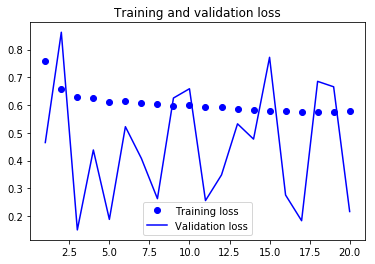

In [7]:
import matplotlib.pyplot as plt

dice = history.history['dice_metric']
val_dice = history.history['val_dice_metric']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(dice) + 1)
plt.figure(1)
_ = plt.plot(epochs, dice, 'bo', label='Training dice')
_ = plt.plot(epochs, val_dice, 'b', label='Validation dice')
plt.title('Training and validation dice scores')
_ = plt.legend()
plt.figure(2)
_ = plt.plot(epochs, loss, 'bo', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
_ = plt.legend()

In [8]:
def mask2rle(mask):
    height = mask.shape[0]
    width = mask.shape[1]
    reshaped_mask = mask.reshape(height*width, order="F")
    rle = ""
    previous_equals_zero = True
    reshaped_mask_length = len(reshaped_mask)
    for i in range(reshaped_mask_length):
        if (reshaped_mask[i] == 1.0) and previous_equals_zero:
            previous_equals_zero = False
            start_index = i
            if i == reshaped_mask_length - 1:
                one_sequence_length = 1
                rle = rle + " " + str(start_index) + " " + str(one_sequence_length)
        elif (reshaped_mask[i] == 0.0) and (not previous_equals_zero):
            previous_equals_zero = True
            one_sequence_length = i - start_index
            rle = rle + " " + str(start_index) + " " + str(one_sequence_length)
        elif (reshaped_mask[i] == 1.0) and (not previous_equals_zero) and (i == reshaped_mask_length-1):
            one_sequence_length = i - start_index + 1
            rle = rle + " " + str(start_index) + " " + str(one_sequence_length)
    rle = rle[1:]
    return rle

In [9]:
from keras.preprocessing.image import load_img, img_to_array
from numpy import squeeze

the_image = load_img("/kaggle/input/severstal-steel-defect-detection/test_images/1804f41eb.jpg", target_size=(the_height, the_width))
image_array = img_to_array(the_image)
image_array = expand_dims(image_array, 0)
predicted_mask = model.predict(image_array, batch_size=1)
predicted_mask = squeeze(predicted_mask, 0)
predicted_rle = mask2rle(predicted_mask)
print("predicted rle:")
print(predicted_rle)

predicted rle:
0 289657 289669 243 289925 243 290181 243 290437 242 290694 241 290950 241 291206 240 291462 240 291718 240 291974 252 292230 251 292486 237 292742 237 292999 237 293255 236 293511 251 293767 234 294023 490 294534 235 294790 235 295045 250 295301 249 295556 249 295812 236 296068 234 296324 235 296579 235 296835 234 297090 235 297346 235 297601 236 297857 235 298113 234 298368 235 298624 235 298880 235 299136 234 299392 234 299648 235 299903 235 300159 235 300414 237 300669 239 300922 243 301176 245 301432 23159 324608 235 324864 236 325120 234 325376 233 325633 231 325889 231 326145 231 326398 234 326654 234 326909 235 327165 235 327422 235 327678 235 327934 235 328183 243 328437 59680 388129 499 388641 242 388897 18993 407899 247 408154 249 408410 250
